Assignment 3
---
1. Go to the site here: https://psl.noaa.gov/data/climateindices/list/ and pick a climate index. You can use pandas or numpy to read in the data. Remember to read the documentation for it!

2. Using your data, build a composite map for the relevant "phases" or conditions (positive, negative, neutral) for your index.

3. Plot the differences against neutral conditions. If your index doesn't have a neutral condition, make a comparison between positive and negative phases in your index.

4. Use an appropriate statistical test for your data and mark the regions in your differences map where the differences are statistically significant using stippling, hatching, or transparency.



In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as features

import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.filterwarnings('ignore')

/home/dadjei2/miniforge/envs/climate/lib/python3.12/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [9]:
# read nino34 data
# file_nino34 = '/home/lortizur/clim680//nino34_1982-2019.oisstv2_anoms.nc'
file_nino34 = 'nino34_1982-2019.oisstv2_anoms.nc'
ds_nino34 = xr.open_dataset(file_nino34)
ds_nino34

<xarray.Dataset> Size: 9kB
Dimensions:  (time: 456)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1982-01-01 1982-02-01 ... 2019-12-01
    month    (time) int64 4kB ...
Data variables:
    sst      (time) float32 2kB ...

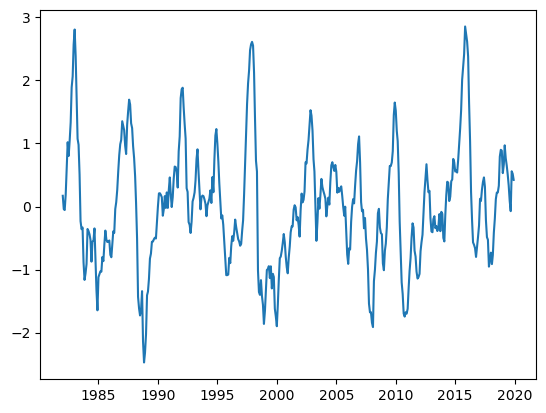

In [10]:
# plot ENSO data
plt.plot(ds_nino34['time'], ds_nino34['sst'])

El Nino:  61
Neutral:  330
La Nina:  65
[array(61), array(65), array(330)]


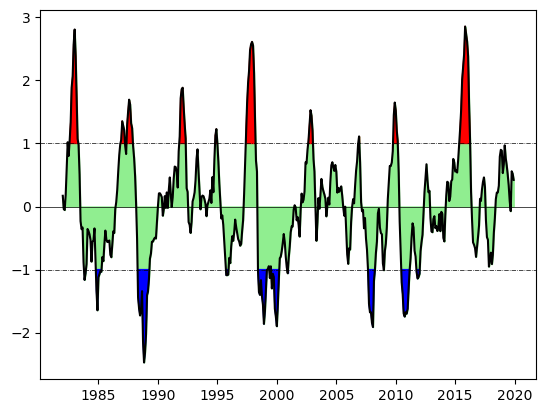

In [11]:
# Define El-Nino, La nina and neutral phases
elnino=ds_nino34['sst'].where(ds_nino34['sst']>=1)
lanina=ds_nino34['sst'].where(ds_nino34['sst']<=-1)
# neutral=ds_nino34['sst'].where(np.logical_and(ds_nino34['sst']>-1,
#                                               ds_nino34['sst']<1))

# Alternative to deducing the neutral
neutral = ds_nino34['sst'].where((ds_nino34['sst']>-1) & (ds_nino34['sst']<1))

print('El Nino: ',elnino.count(dim='time').values)
print('Neutral: ',neutral.count(dim='time').values)
print('La Nina: ',lanina.count(dim='time').values)

counts=[elnino.count(dim='time').values,
        lanina.count(dim='time').values,
        neutral.count(dim='time').values]
print(counts)

plt.plot(ds_nino34['time'],ds_nino34['sst'],'k')
plt.fill_between(ds_nino34['time'].values,ds_nino34['sst'],color='lightgreen')
plt.fill_between(ds_nino34['time'].values,elnino,y2=1.0,color='red')
plt.fill_between(ds_nino34['time'].values,lanina,y2=-1.0,color='blue')
plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(1,color='black',linewidth=0.5,linestyle='dashdot')#'dotted')
plt.axhline(-1,color='black',linewidth=0.5,linestyle='dashdot')#'dotted') ;

Load Sea Surface Temperature (SST) data
---

In [22]:
ds_sst=xr.open_dataset('sst.mon.mean.nc')
ds_sst

<xarray.Dataset> Size: 412MB
Dimensions:  (lat: 180, lon: 360, time: 1590)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 13kB 1891-01-01 1891-02-01 ... 2023-06-01
Data variables:
    sst      (time, lat, lon) float32 412MB ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

In [23]:
da_sst = ds_sst.sst.sel(time=slice(ds_nino34['time'][0],ds_nino34['time'][-1]))

da_mean = da_sst.groupby('time.month').mean()
da_anoms = da_sst.groupby('time.month')-da_mean
# da_anoms

Select dates that match El Nino, La Nina, and Neutral
---

In [24]:
elnino_sst = da_anoms.sel(time=elnino.dropna(dim='time')['time']).mean(dim='time')
lanina_sst = da_anoms.sel(time=lanina.dropna(dim='time')['time']).mean(dim='time')
neutral_sst = da_anoms.sel(time=neutral.dropna(dim='time')['time']).mean(dim='time')

comp_precip = [elnino_sst,lanina_sst,neutral_sst]
# comp_precip

In [55]:
#  ('nino', 'nina', 'neutral')

# precip_dict = {'nino':elnino_precip,
#               'nina':lanina_precip,
#               'neutral':neutral_precip}

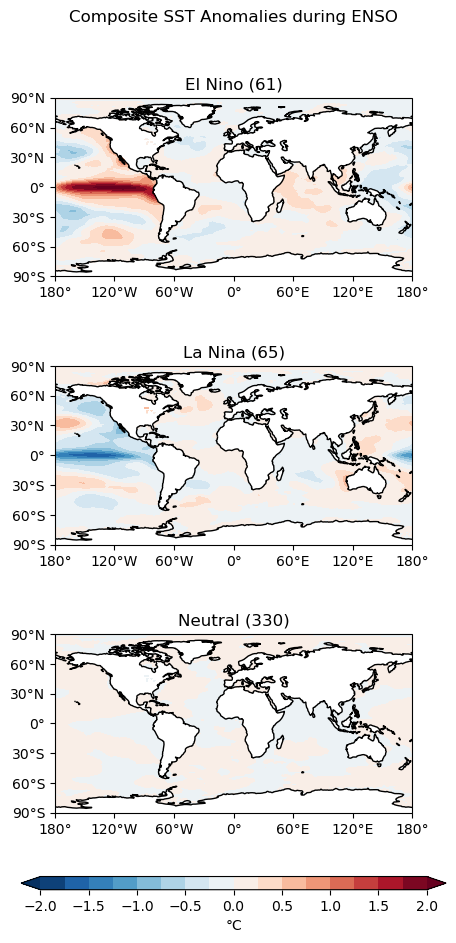

In [25]:
labels=['El Nino','La Nina', 'Neutral']
clevs = np.arange(-2.0,2.1,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(comp_precip):

        # Select the season
        data = comp_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='\u00B0C')

# Add a big title at the top
plt.suptitle('Composite SST Anomalies during ENSO');

In [26]:
# calculating the difference
diff_precip=[elnino_sst-neutral_sst, 
             lanina_sst-neutral_sst]

Text(0.5, 0.98, 'Composite SST Differences during ENSO')

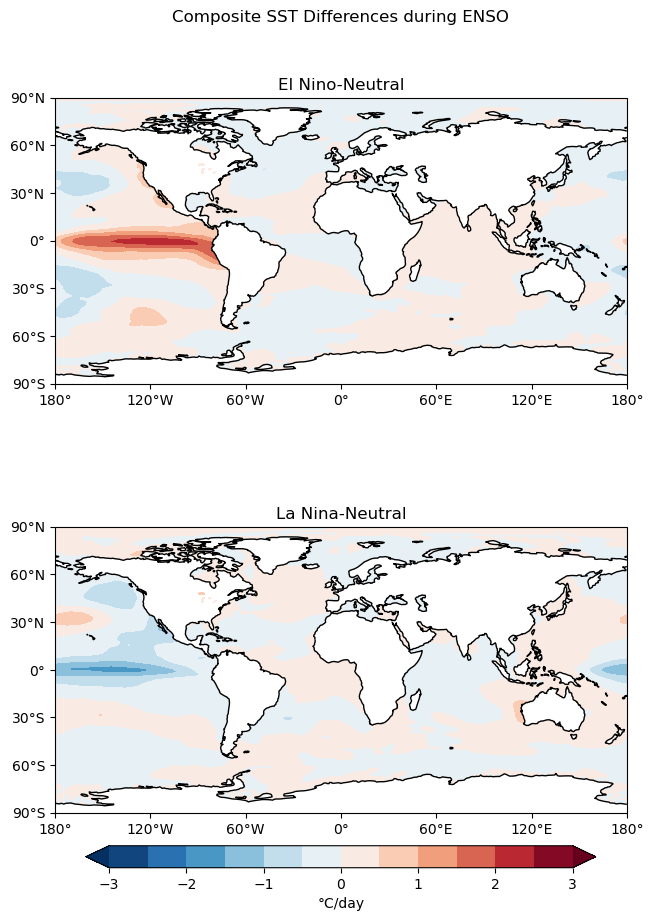

In [27]:
labels=['El Nino-Neutral','La Nina-Neutral']
clevs=np.arange(-3,3.5,0.5)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(diff_precip):

        # Select the season
        data=diff_precip[i]

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=diff_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,diff_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='RdBu_r',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()

        # Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='\u00B0C/day')

# Add a big title at the top
plt.suptitle('Composite SST Differences during ENSO')

In [28]:
p = 0.05 # 95% confidence level, or 5% likelihood that the result arose by chance

In [29]:
from scipy.stats import ttest_ind

elnino_precip_vals = da_anoms.sel(time=elnino.dropna(dim='time')['time'])
lanina_precip_vals = da_anoms.sel(time=lanina.dropna(dim='time')['time'])
neutral_precip_vals = da_anoms.sel(time=neutral.dropna(dim='time')['time'])

In [30]:
tstat,pval = ttest_ind(elnino_precip_vals, 
                neutral_precip_vals, 
                equal_var = False)

In [31]:
mask_diff = diff_precip[0].where(pval <= p)
mask_diff

<xarray.DataArray 'sst' (lat: 180, lon: 360)> Size: 259kB
array([[-0.03325804, -0.03387187, -0.0341603 , ..., -0.03275456,
        -0.03314795, -0.03313044],
       [        nan, -0.01401644, -0.01410431, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

Text(0.5, 0.98, 'Composite SST Differences El Nino-Neutral')

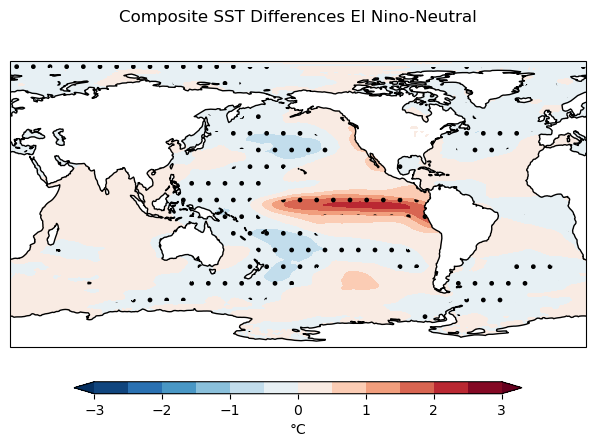

In [35]:
labels=['El Nino vs. Neutral']
clevs=np.arange(-3,3.5,0.5)
hatch_levs=[0]

# Define the figure and each axis for the 2 rows and 1 columns
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})


data=diff_precip[0]

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_precip[0]['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_precip[0]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_precip[0]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='RdBu_r',extend='both')

# Overlay of stippling
ss=axs.contourf(lons,diff_precip[0]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['.',''],extend='both',alpha=0.0)

# Draw the coastines for each subplot
axs.coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='\u00B0C')

# Add a big title at the top
plt.suptitle('Composite SST Differences El Nino-Neutral')
